# Growing Neural Cellular Automata

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.conv_perceive import ConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils.emoji import get_emoji
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [2]:
seed = 0

channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 128
learning_rate = 2e-3

emoji = "🦎"
target_size = 40
target_padding = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

2024-10-24 09:03:42.203053: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Dataset

""

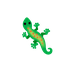

In [3]:
target = get_emoji(emoji, size=target_size, padding=target_padding)

mediapy.show_image(target)

## Init state

In [4]:
def init_state():
	state_shape = target.shape[:2] + (channel_size,)

	state = jnp.zeros(state_shape)
	mid = tuple(size // 2 for size in state_shape[:-1])
	return state.at[mid[0], mid[1], -1].set(1.0)

## Model

In [5]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
)

In [7]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.conv.kernel = nnx.Param(kernel)

In [8]:
ca = CA(perceive, update)

In [9]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 8768


## Train

### Pool

In [10]:
state = jax.vmap(lambda _: init_state())(jnp.zeros(pool_size))

pool = Pool.create({"state": state})

### Optimizer

In [11]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [12]:
def mse(state):
	return jnp.mean(jnp.square(state_to_rgba(state) - target))

In [13]:
@nnx.jit
def loss_fn(ca, state, key):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps, all_steps=True),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Sample a random step
	index = jax.random.randint(key, (state.shape[0],), num_steps // 2, num_steps)
	state = state[jnp.arange(state.shape[0]), index]

	loss = mse(state)
	return loss, state

### Train step

In [14]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	sample_key, loss_key = jax.random.split(key)

	# Sample from pool
	pool_index, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(mse)(current_state), descending=True)
	pool_index = pool_index[sort_index]
	current_state = current_state[sort_index]

	# Sample a new target to replace the worst
	new_state = init_state()
	current_state = current_state.at[0].set(new_state)

	(loss, current_state), grad = nnx.value_and_grad(loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params))(
		ca, current_state, loss_key
	)
	optimizer.update(grad)

	pool = pool.update(pool_index, {"state": current_state})
	return loss, pool

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.6e}"})

## Visualize

In [16]:
state = jax.vmap(lambda _: init_state())(jnp.zeros(8))

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=8)(
	nnx.vmap(
		lambda ca, state: ca(state, num_steps=2 * num_steps, all_steps=True),
		in_axes=(state_axes, 0),
	)
)(ca, state)

,,,,,,,

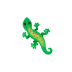
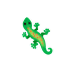
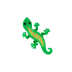
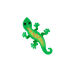
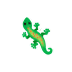
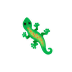
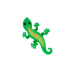
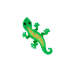

In [20]:
mediapy.show_images(state_from_rgba_to_rgb(state[:, -1]), width=128, height=128)

,,,,,,,

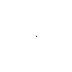
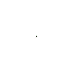
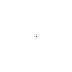
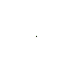
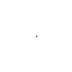
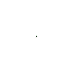
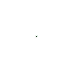
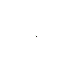

In [21]:
mediapy.show_videos(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")